# Create lines



In [2]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path

# system paths
import sys
home = str(Path.home())
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'
from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

# aws connection
import boto3
import awswrangler as wr

# local libraries
from src import utils

# analysis libraries
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon, LineString, GeometryCollection, shape
from shapely import wkt
from shapely.ops import transform
import shapely

from multiprocessing.pool import Pool
from functools import partial

from loguru import logger

cm = str(datetime.today().strftime("%Y%m%d%H%m"))
cm

'202108101808'

## Download sample

Query Athena once to download lines count to calculate jams

In [ ]:
# Download data from Athena
update_data = False
if update_data:
    conn = utils.connect_athena(path='../configs/athena.yaml')
    qry = f"""
        select line_wkt, count(line_wkt) as count_lines
        from spd_sdv_waze_corona.raw_copy_jams
        group by line_wkt"""
    #df_lines = pd.read_sql_query(qry, conn)
# df_lines.to_csv('/home/soniame/private/line_wkt_count_202010701.csv', index=False)

# Read current table
df_lines = pd.read_csv('/home/soniame/private/projects/corona_geo_id/lines/line_wkt_count_202010701.csv')
print(df_lines.shape)

In [ ]:
df_lines.head(3)

## Polygons definitions

In [ ]:
# - Example 
# polygon = 'POLYGON((2.0117187499999822 44.38657313925715,-19.433593750000018 19.207272119703983,19.414062499999982 6.904449621538131,64.94140624999999 -3.096801256840523,81.46484374999999 37.21269961002643,45.78124999999998 24.106495997107682,53.69140624999998 51.22054369437158,3.7695312499999822 37.07257833232809,2.0117187499999822 44.38657313925715))'
# - Latin America 
# polygon = 'POLYGON ((-127.265625 34.30714385628804, -128.671875 -56.94497418085159, -28.4765625 -57.70414723434192, -29.8828125 16.97274101999902, -84.72656249999999 25.48295117535531, -116.71874999999999 35.746512259918504, -127.265625 34.30714385628804))'
# - Triángulo 
# polygon = Polygon([(0, 0), (5, 5), (5, 0)])
# - Peru
# polygon = 'POLYGON ((-77.10205078124999 -13.004557745339769, -72.158203125 -13.004557745339769, -72.158203125 -8.90678000752024, -77.10205078124999 -8.90678000752024, -77.10205078124999 -13.004557745339769))'
# - Latin america BID
polygon = 'POLYGON((-129.454 37.238,-90.781 27.311,-67.117 20.333,-68.721 17.506,-23.765 -9.114,-65.601 -60.714,-126.421 -23.479,-129.454 37.238))'
geometry = wkt.loads(polygon)
print(geometry.area)
geometry

## Coarse grid

In [ ]:
from babelgrid import Babel
import numpy as np
import folium


# list of logical values if tiles belong
def line_to_coarse(line):
    
    logger.debug(f"{line}")
    # grid tiles intersection per line
    inter_list = list()
    for tile in tiles:
        geom = tile.geometry.shapely
        inter_list.append(geom.intersection(wkt.loads(line)).is_empty == False)
        
    # wkt assigned to each line
    if sum(inter_list) == 0:
        # In case there's no intersection
        pos = None
        t_wkt = ""
    else:
        pos = np.where(inter_list)[0].tolist()[0]  
        t_wkt = tiles[pos].geometry.wkt
    
    result = {'line': line, 'coarse_grid': t_wkt}
    logger.debug(f"{pos} : {result}")
    
    return(result)


In [ ]:
# H3 cells grid
tiles = Babel('h3').polyfill(geometry, resolution=1)
# S2 cells grid
#tiles = Babel('s2').polyfill(geometry, resolution=4)

len(tiles)

if False:
    tiles_gdf = gpd.GeoDataFrame([t.to_dict() for t in tiles], geometry='shapely')
    df = tiles_gdf
    m = folium.Map(location=[40.70, -73.94], zoom_start=2, tiles='CartoDB positron')
    for _, r in df.iterrows():
        # Without simplifying the representation of each borough,
        # the map might not be displayed
        sim_geo = gpd.GeoSeries(r['shapely']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'fillColor': 'orange'})
        geo_j.add_to(m)
    m

In [ ]:
# Partial processing
with Pool(10) as p:
    r = p.map(partial(line_to_coarse), df_lines.line_wkt)
    
df_coarse = pd.DataFrame(r)

In [ ]:
df_coarse

### Coarse grid distribution

In [18]:
df_coarse = pd.read_csv("/home/soniame/private/projects/corona_geo_id/coarse_grid/coarse_id.csv")

In [37]:
print(len(df_coarse))
print(len(df_coarse.drop_duplicates()))
df_coarse.head(1)

1175153
1175153


,line,coarse_wkt
0,"LINESTRING(-75.097855 4.448101, -75.098718 4.4...",POLYGON ((-77.4406988355037527 5.5631423675199...


In [43]:
from siuba import group_by, ungroup, arrange, summarize, _

In [44]:
tab = (df_coarse
  >> group_by(_.coarse_wkt)
  >> summarize(lines = _.line.count())
  >> ungroup()
  >> arrange("lines")
  )
tab.to_csv('/home/soniame/private/projects/corona_geo_id/coarse_grid_distribution.csv', index = False)
tab.head()

,coarse_wkt,lines
32,POLYGON ((-71.0160747003524904 0.9012742714960...,1
50,POLYGON ((-91.1200710613694156 7.0595086138102...,1
36,POLYGON ((-73.5965043621200294 -56.21061073758...,9
46,POLYGON ((-83.8912484679536021 21.244199241429...,10
19,POLYGON ((-58.3490652436454980 -45.66994098673...,15


<AxesSubplot:>

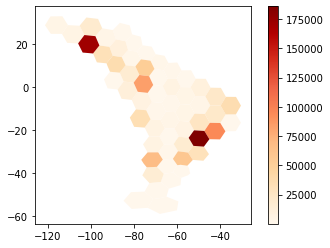

In [40]:
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['coarse_wkt'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

## MultiLineString geometry

Testing the creation of MultiLineString

In [ ]:
from shapely.geometry import MultiLineString
#line_a = LineString(wkt.loads(line))
lines = [LineString(wkt.loads(line)) for line in df_lines.line_wkt]

In [ ]:
len(lines)
multi_line = MultiLineString(lines)
print(multi_line.length)
multi_line

In [ ]:
result = geometry.intersection(multi_line)

In [ ]:
times = [intersection_func(line, geometry) for line in df_lines.line_wkt[:5]]
total_lines = df_lines.count_lines
intersection = sum([times[x]*total_lines[x] for x in range(len(total))])
intersection

## Creating squares

In [ ]:
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
from shapely.wkt import loads

def intersection_func(line, geometry):
    result = geometry.intersection(wkt.loads(line)).is_empty == False
    return(int(result))

def threshold_density_func(geometry, threshold_value):
    """Compares the threshold values with the number of lines"""
    
    print('Running')
    
    # Intersection of lines within square
    times = [intersection_func(line, geometry) for line in df_lines.line_wkt]
    total_lines = df_lines.count_lines
    
    # Total lines in square
    intersection = sum([times[x]*total_lines[x] for x in range(len(total))])
    total = sum(total_lines)
    
    print(f"Intersection {intersection}")
    print(f"Total lines {total}")
    print(f"Proportion {intersection/total}")
    
    return (intersection/total) < (threshold_value/total)

In [ ]:
len(df_lines.line_wkt)

In [ ]:
result = osmpy.core.katana(geometry, 
                           threshold_func = threshold_density_func, 
                           threshold_value = 110000, 
                           count = 100)

In [ ]:
len(result)

In [ ]:
multipolygon = MultiPolygon(result)
multipolygon

In [ ]:
grid = list()
for polygon in MultiPolygon(result):  # same for multipolygon.geoms
    grid.append(str(polygon))

In [ ]:
cm = str(datetime.today().strftime("%Y%m%d%H%m%s"))
print(cm)

In [ ]:
outdf = gpd.GeoDataFrame(columns=['geometry'])
outdf['geometry'] = grid
outdf.to_csv(f"~/private/geo_id_polygon/geo_grid_area_{cm}.csv")

## Lines intersection per square



In [ ]:
def intersection_line(line, geometry):
    #print(line)
    line_wkt = wkt.loads(str(line))
    result = geometry.intersection(line_wkt)
    
    return(result)

In [ ]:
df_lines['geo_id'] = ""
#df_lines.head()

In [ ]:
for polygon in outdf.geometry:
    print(polygon)
    
    geometry = wkt.loads(polygon)
    lines = df_lines[df_lines['geo_id'] == ''].line_wkt
    if len(lines) > 0:
        # print(len(lines))
        intersect = [intersection_func(line, geometry) for line in df_lines.line_wkt]
        df_lines.loc[[x > 0 for x in intersect], 'geo_id'] = polygon
    

In [ ]:
# Export 
df_lines.to_csv(f"~/private/geo_id_polygon/line_wkt_area_geo_id_{cm}.csv", index = False)

### Distribution of lines/jams per square

In [ ]:
from siuba import group_by, ungroup, arrange, summarize, _
import geopandas as gpd
import folium

In [ ]:
#df_geo_id = pd.read_csv(f"/home/soniame/private/projects/corona_geo_id/intersection/geo_grid_area_geo_id_2021073017071627679286.csv")
print(df_geo_id.shape)
df_geo_id.head()

In [ ]:
tab = (df_geo_id
  >> group_by(_.geo_id)
  >> summarize(lines = _.line_wkt.count())
  >> ungroup()
  >> arrange("lines")
  )
tab['geometry'] = gpd.GeoSeries.from_wkt(tab['geo_id'])
tab = gpd.GeoDataFrame(tab, geometry='geometry')

tab.head()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
tab.plot(column='lines', ax=ax, legend=True, cmap='OrRd')

In [ ]:
df = tab
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['lines']).add_to(geo_j)
    geo_j.add_to(m)
m

In [ ]:
#centroid = tiles[0].geometry.centroid
#m = folium.Map(location=(centroid.latitude, centroid.longitude))


In [ ]:
for tile in tiles:
    folium.GeoJson(tile.geometry.geojson).add_to(m)
m